### Abstract

This notebook showcases on how to build a [GAN](https://arxiv.org/pdf/1406.2661.pdf) (Generative Adversary Network) with [the pytorch framwork](http://pytorch.org/). It is inspired and adapted from [the blog post of medium.com](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9).


In [62]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at 
# https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

In [23]:
# ##### DATA: Target data and generator input data

dtype = torch.cuda.FloatTensor
#dtype = torch.FloatTensor


def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian


In [24]:
# ##### MODELS: Generator model and discriminator model
#%time

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast).cuda(), exponent)
    return torch.cat([data, diffs], 1)


In [25]:
# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

Using data [Data and variances]


In [26]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector

d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)

num_epochs = 30000
#num_epochs = 30000
print_interval = 200

d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [27]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()

G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)

# Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
criterion = nn.BCELoss()

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

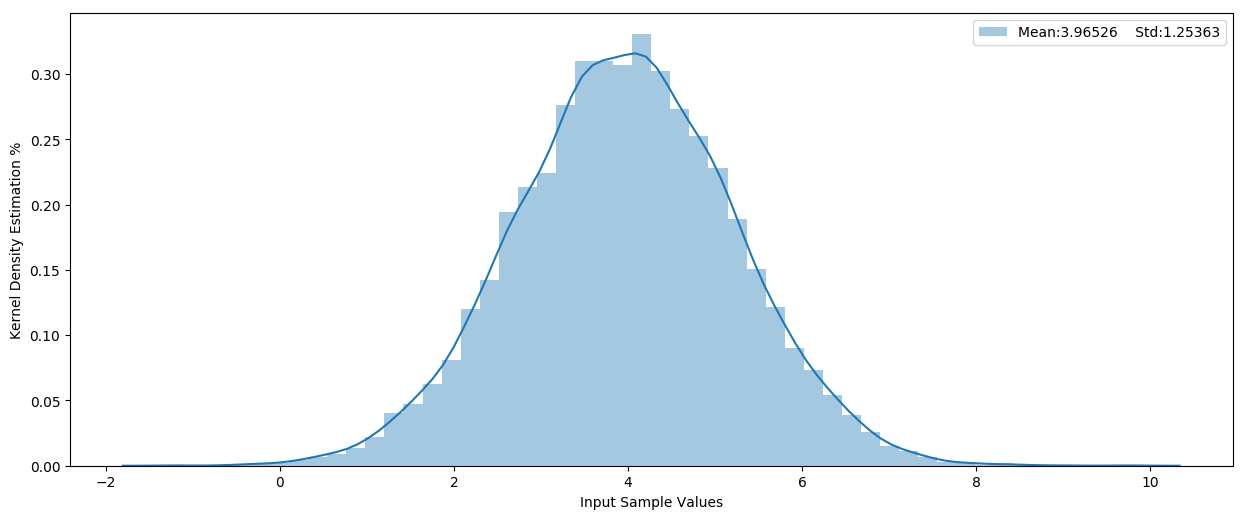

In [93]:

input_samples = d_sampler(10000).numpy()[0]

legend = "Mean:" + str(input_samples.mean()) + \
         "    Std:" + str(input_samples.std())

ax = sns.distplot(input_samples, kde=True, label=legend, axlabel='Input Sample Values')
ax.set_ylabel("Kernel Density Estimation %")
_ = ax.legend()

Text(0,0.5,'count')

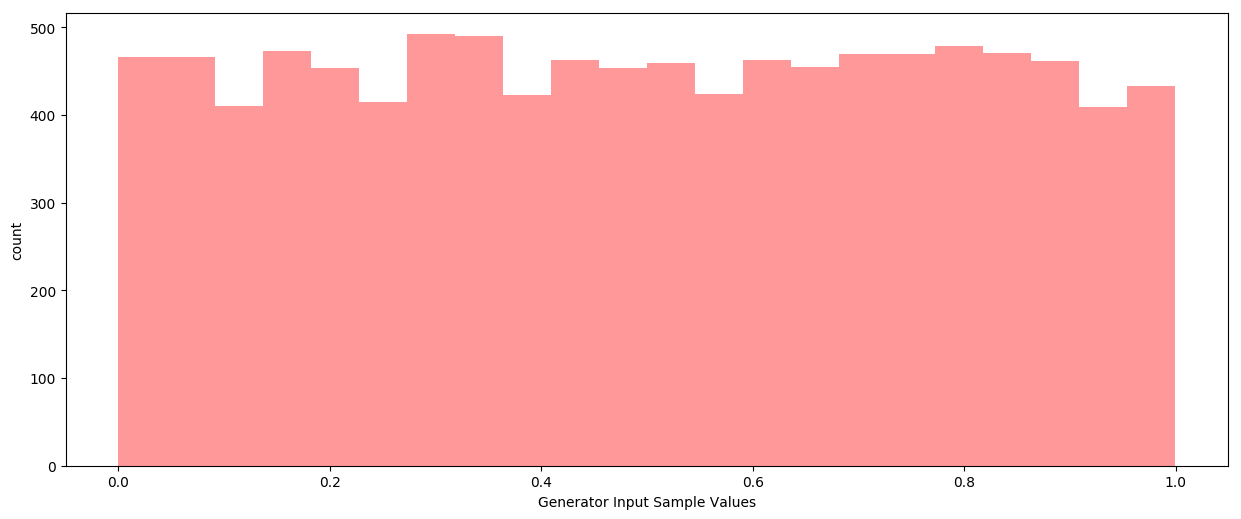

In [104]:
generator_input_samples = gi_sampler(10000, 1)


ax = sns.distplot(generator_input_samples.numpy(), hist=True, kde=False, color='r')
ax.set_xlabel('Generator Input Sample Values')
ax.set_ylabel('count')


Run the networks on GPU

In [28]:
G = G.cuda()
D = D.cuda()
criterion = criterion.cuda()

In [29]:

def train_GAN(num_epochs):
    '''
    '''
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size)).cuda()
        
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones(1).cuda()))  # ones = true
            # compute/store gradients, but don't change params
            d_real_error.backward()
            
            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)).cuda()).cuda()  # zeros = fake
            d_fake_error.backward()
            # Only optimizes D's parameters; changes based on stored gradients from backward()
            d_optimizer.step()  
            
        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            # we want to fool, so pretend it's all genuine
            g_error = criterion(dg_fake_decision, Variable(torch.ones(1)).cuda()) 
            
            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

        if epoch % print_interval == 0:
            print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                                extract(d_real_error)[0],
                                                                extract(d_fake_error)[0],
                                                                extract(g_error)[0],
                                                                stats(extract(d_real_data)),
                                                                stats(extract(d_fake_data))))

In [31]:
%%time

print('Total epochs:', num_epochs)

#train_GAN(num_epochs)


Total epochs: 30000
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 704 µs
